## 📝 Predicting Hight Traffic Recipes

Project Steps:

- Data Validation:   
  - Describes validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Includes two different graphics that demonstrates the characteristics of data  
  - Includes two graphs that demonstrate the relationship between features
  - Describes the findings
- Model Development
  - Includes the reasons for selecting the models we use as well as a statement of the problem type
  - Codes to fit the baseline and comparison models
- Model Evaluation
  - Describes the performance of the two models based on an appropriate metric
- Business Metrics
  - Defines a way to compare our model performance to the business goal.
  - Describes how our models perform using this approach
- Final summary including recommendations that the business should undertake

Load the necessary libraries first:

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load the dataset:

In [101]:
recipe_data = pd.read_csv('recipe_site_traffic_2212.csv')

recipe_data.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


**DATA VALIDATION**

Check the columns of the dataset at hand:

In [102]:
recipe_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


The original index seems to be redundant. We will reset the index to the 'recipe' column. 

In [103]:
recipe_data.set_index('recipe', inplace=True)

Check the number of recipes for each category: 

In [104]:
recipe_data['category'].value_counts()

category
Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: count, dtype: int64

Change 'Chicken Breasts' category to 'Chicken' to avoid confusion. 

In [105]:
recipe_data['category'] = recipe_data['category'].replace('Chicken Breast', 'Chicken')
recipe_data['category'].value_counts()

category
Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Vegetable         83
Dessert           83
Meat              79
One Dish Meal     71
Name: count, dtype: int64

Check the 'servings' column:

In [106]:
recipe_data['servings'].value_counts()

servings
4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64

We observe two vague serving values: '4 as a snack' and '6 as a snack.' We will replace these with 4 and 6 respectively. Now that the servings column only contains numeric values, we change the datatype of that column to integer.

In [107]:
recipe_data['servings'] = recipe_data['servings'].replace({'4 as a snack': '4', '6 as a snack': '6'})
recipe_data['servings'] = recipe_data['servings'].astype(int)
recipe_data['servings'].value_counts()


servings
4    391
6    198
2    183
1    175
Name: count, dtype: int64

Check the proportion of missing data entries for each column in the dataset:

In [108]:
missing_proportion = recipe_data.isnull().mean() * 100
print(missing_proportion)

calories         5.491024
carbohydrate     5.491024
sugar            5.491024
protein          5.491024
category         0.000000
servings         0.000000
high_traffic    39.387540
dtype: float64


 We noticed a hight proportion of missing values in the 'high traffic' variable. We assume that the null values represent low traffic rather than a missing observation. It will now make more sense to rename these values to 'Low.'

In [109]:
recipe_data['high_traffic'] = recipe_data['high_traffic'].fillna('Low')

Check the reorganized dataset:

In [110]:
recipe_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      895 non-null    float64
 1   carbohydrate  895 non-null    float64
 2   sugar         895 non-null    float64
 3   protein       895 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    int64  
 6   high_traffic  947 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 59.2+ KB


We will later find that the 'category' variable plays a significant role in predicting user traffic level. Therefore, we will not remove rows with missing nutritional data, as they stil have a category. Instead, we will substitute the missing values for the mean of relevant nutritional column of the same recipe category and the number of servings.

In [111]:
numeric_columns = ['calories', 'carbohydrate', 'sugar', 'protein']

# Impute missing values based on the mean of their category
for col in numeric_columns:
    recipe_data[col] = recipe_data.groupby(['category', 'servings'])[col].transform(lambda x: x.fillna(x.mean()))

recipe_data['high_traffic'].fillna('Low', inplace=True)
recipe_data.dropna(subset=numeric_columns, inplace=True)
cleaned_data = recipe_data.isna().sum()
print(cleaned_data)

calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64


**EXPLORATORY DATA ANALYSIS**

Check the distribution for the numeric (macronutrient) variables:

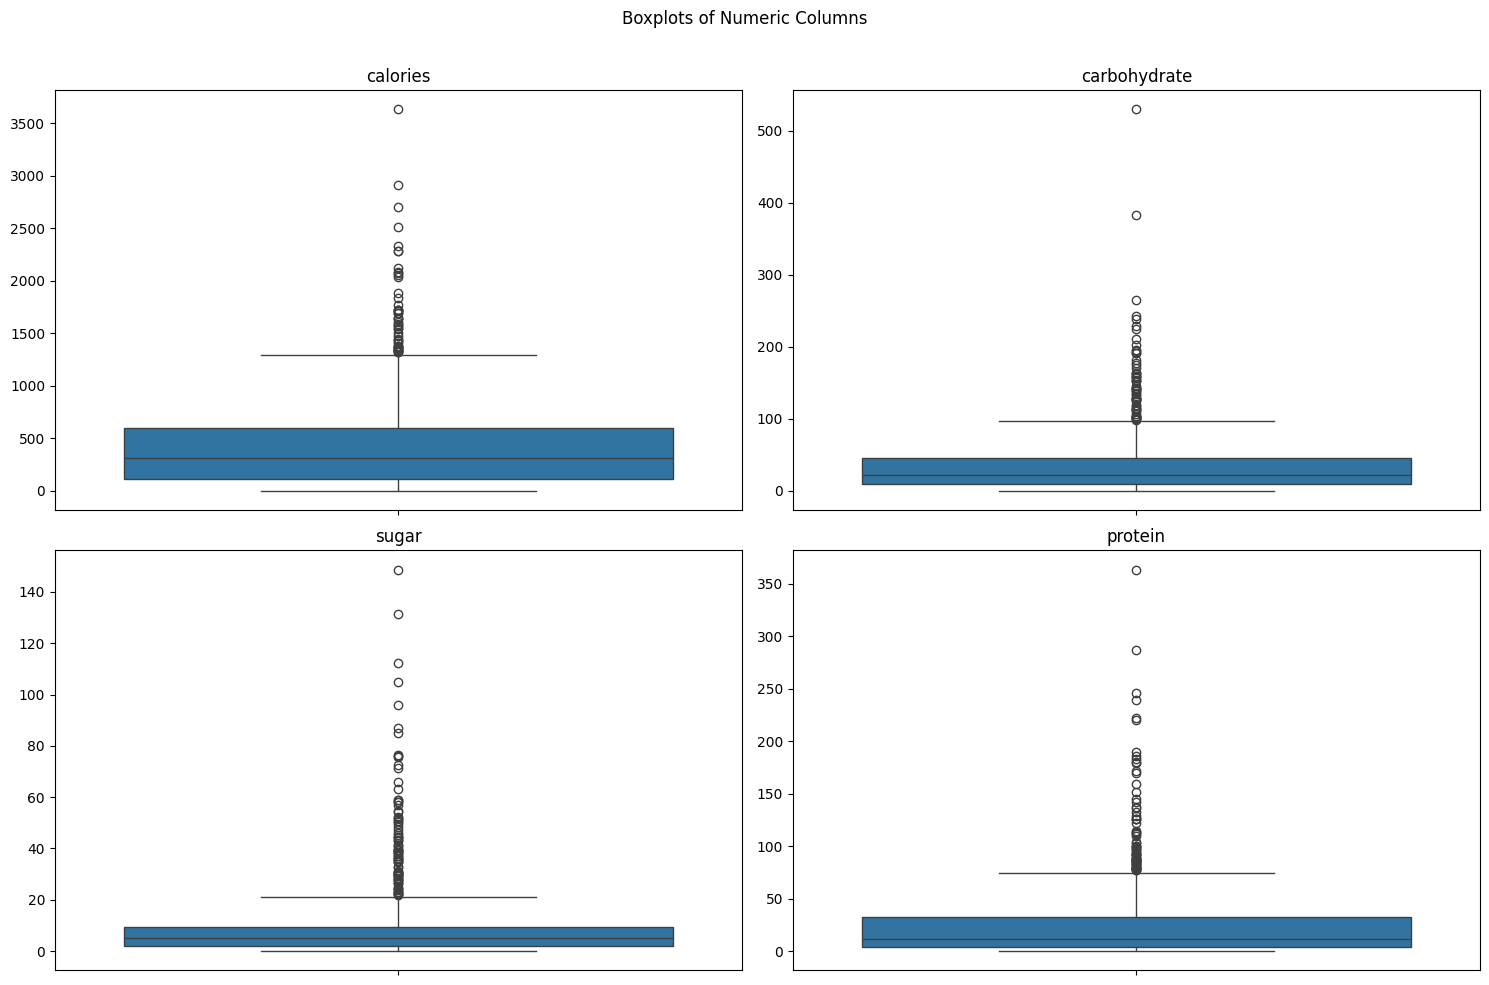

In [112]:
f, axes = plt.subplots(2, 2, figsize=(15, 10))
f.suptitle('Boxplots of Numeric Columns')

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each numeric column's distribution as a boxplot on one of the subplots
for i, col in enumerate(numeric_columns):
    sns.boxplot(y=recipe_data[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Adjust title position
plt.show()


Manually examine the outliers for each macronutrient column:

In [113]:
exclude_columns = 'high_traffic'

for col in numeric_columns:
    Q1 = recipe_data[col].quantile(0.25)
    Q3 = recipe_data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = recipe_data[(recipe_data[col] < (Q1 - 1.5 * IQR)) | (recipe_data[col] > (Q3 + 1.5 * IQR))]
    outliers_display = outliers.drop(columns=exclude_columns)
    outliers_sorted = outliers_display.sort_values(by=col, ascending=False)  # Sort the outliers in descending order
    print(f'Potential outliers for {col}:\n', outliers_sorted)


Potential outliers for calories:
         calories  carbohydrate  sugar  protein       category  servings
recipe                                                                 
926      3633.16         29.07   0.35     2.32        Chicken         4
125      2906.01          3.52   1.89   179.22           Pork         6
227      2703.12          6.40   2.17    28.20           Pork         6
72       2508.47         18.11  10.60    84.23        Chicken         4
908      2332.32          7.47   3.62    34.33  One Dish Meal         1
940      2283.29         34.34   5.12    17.57        Chicken         6
357      2282.60          4.50   4.16    31.19  One Dish Meal         4
56       2122.24         25.99   0.52    81.37           Pork         1
98       2081.69          8.09   4.78    28.48  One Dish Meal         2
782      2068.07         34.23   1.46    10.02         Potato         1
398      2051.34          2.46   2.12    69.62        Chicken         2
637      2029.33         25.08

Delete suspicious outliers:

In [114]:
suspicious_otliers = [926, 451, 350, 739, 682, 696, 343, 168, 454, 694, 22, 343, 541, 576, 762, 368, 262, 541, 816]  

recipe_data = recipe_data.drop(suspicious_otliers)

invalid_rows = (recipe_data['protein'] > recipe_data['calories']) | \
               (recipe_data['carbohydrate'] > recipe_data['calories']) | \
               (recipe_data['sugar'] > recipe_data['calories'])

print(f"Number of invalid rows: {invalid_rows.sum()}")
print(f"Total rows before removal: {len(recipe_data)}")

# Drop the invalid rows
recipe_data = recipe_data[~invalid_rows]

print(f"Total rows after removal: {len(recipe_data)}")


Number of invalid rows: 88
Total rows before removal: 930
Total rows after removal: 842


Check the relationship between macronutrients and traffic level.
 

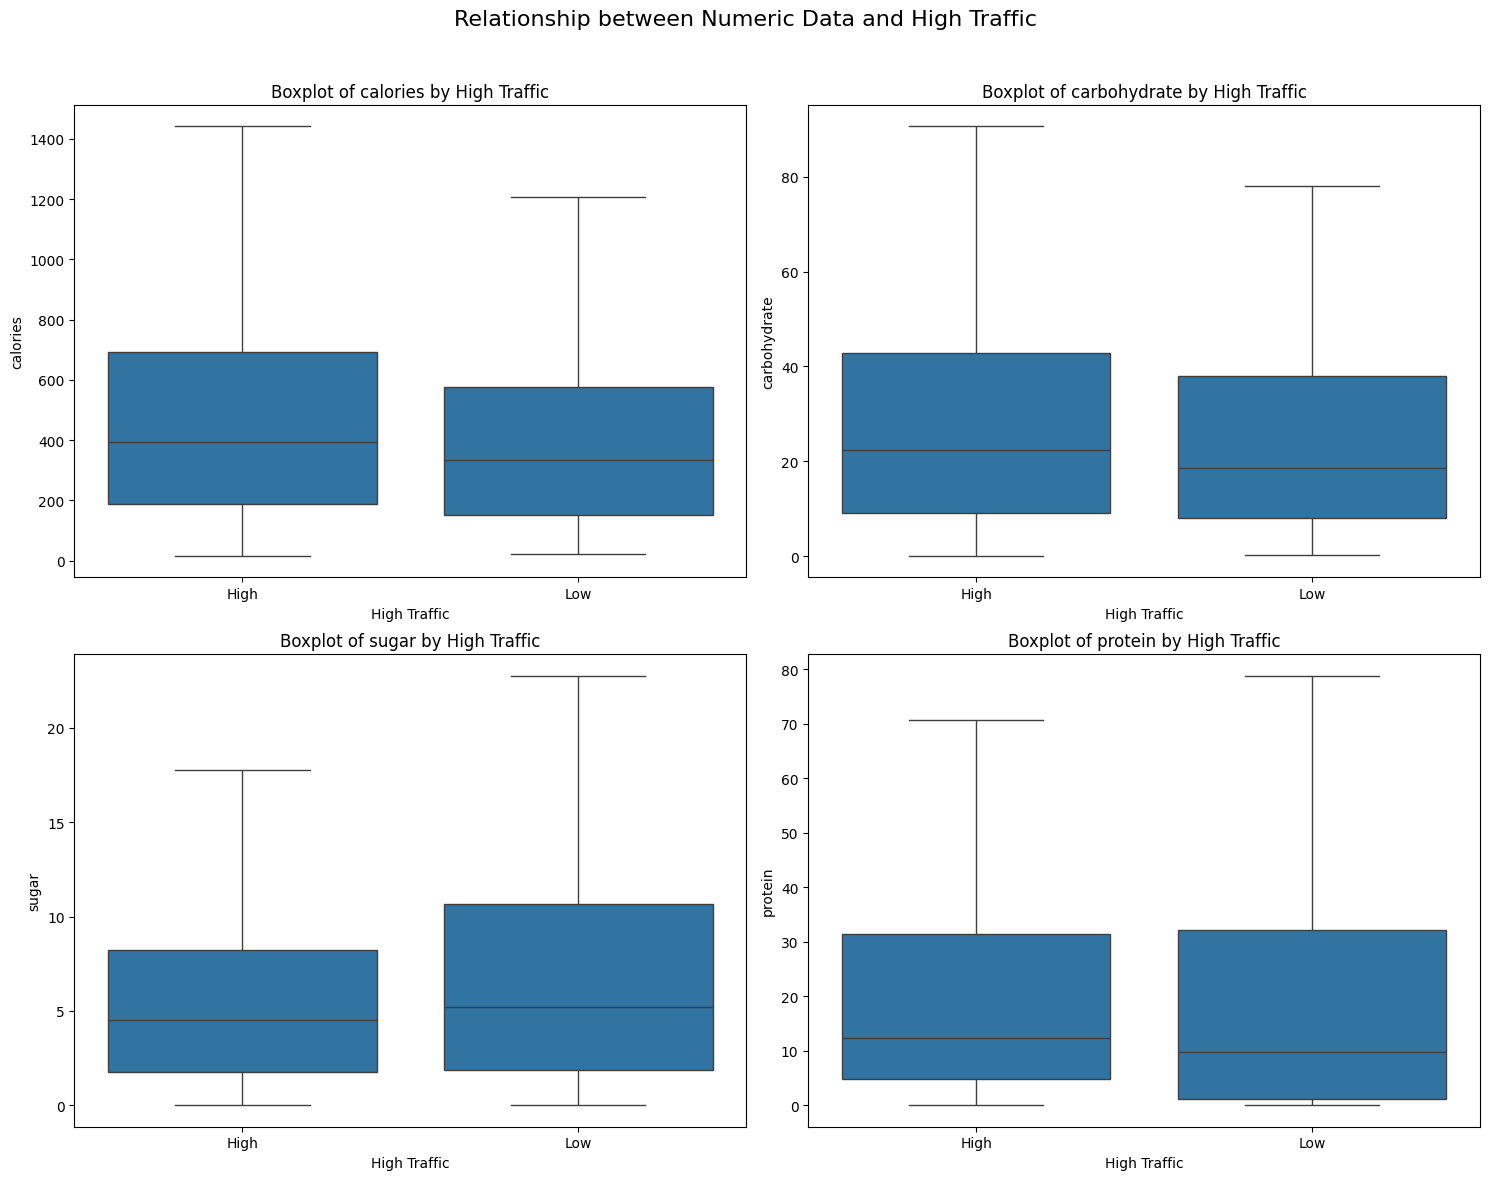

In [115]:
# Set up the 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Relationship between Numeric Data and High Traffic', fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(x='high_traffic', y=col, data=recipe_data, ax=axes[i], showfliers=False)
    
    axes[i].set_title(f'Boxplot of {col} by High Traffic')
    axes[i].set_ylabel(col)
    axes[i].set_xlabel('High Traffic')

plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Adjust title position
plt.show()





We see no immediate correlation here. Let us now check the relationship between the recipe categories and the traffic level:

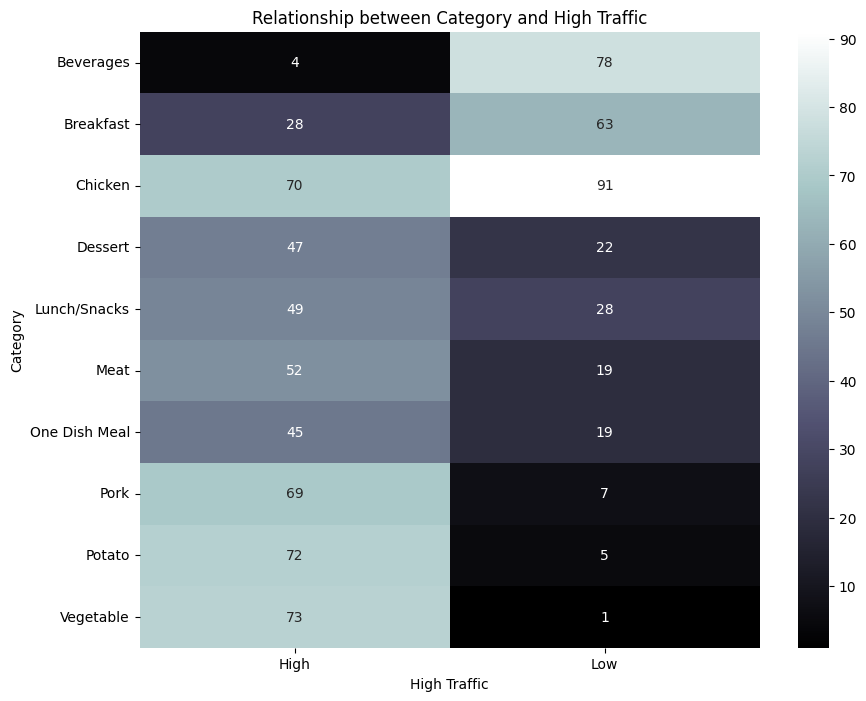

In [116]:
# Create a crosstab of the category and high_traffic columns
ct = pd.crosstab(recipe_data['category'], recipe_data['high_traffic'])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(ct, annot=True, cmap='bone', cbar=True, fmt="d") 
plt.title('Relationship between Category and High Traffic')
plt.xlabel('High Traffic')
plt.ylabel('Category')
plt.show()


We see that certain categories are strongly associated with high traffic levels and vice versa. This preliminary observation indicated that food category could be a good predictor for the recipe's popularity.

**MODEL PRE-PROCESSING**


Before we construct the model, we want to make sure that the macronutrient variables have gaussian distribution to optimize for proportionality. We will aply log-transformation. 

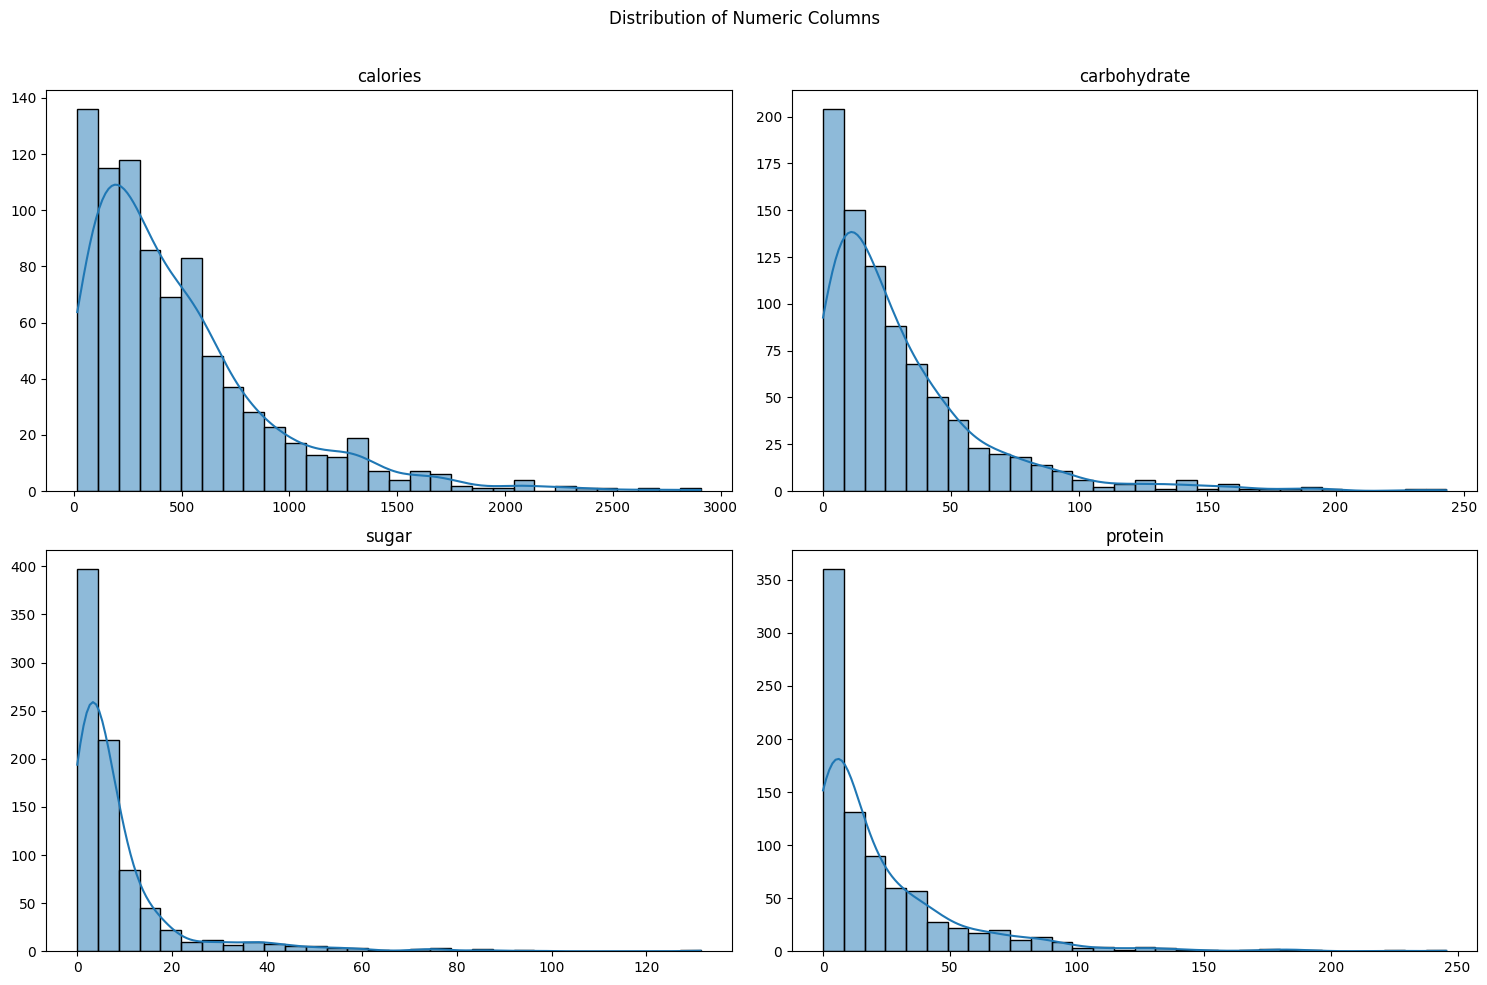

In [117]:

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(15, 10))
f.suptitle('Distribution of Numeric Columns')

axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(recipe_data[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Adjust title position
plt.show()

/opt/homebrew/lib/python3.11/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


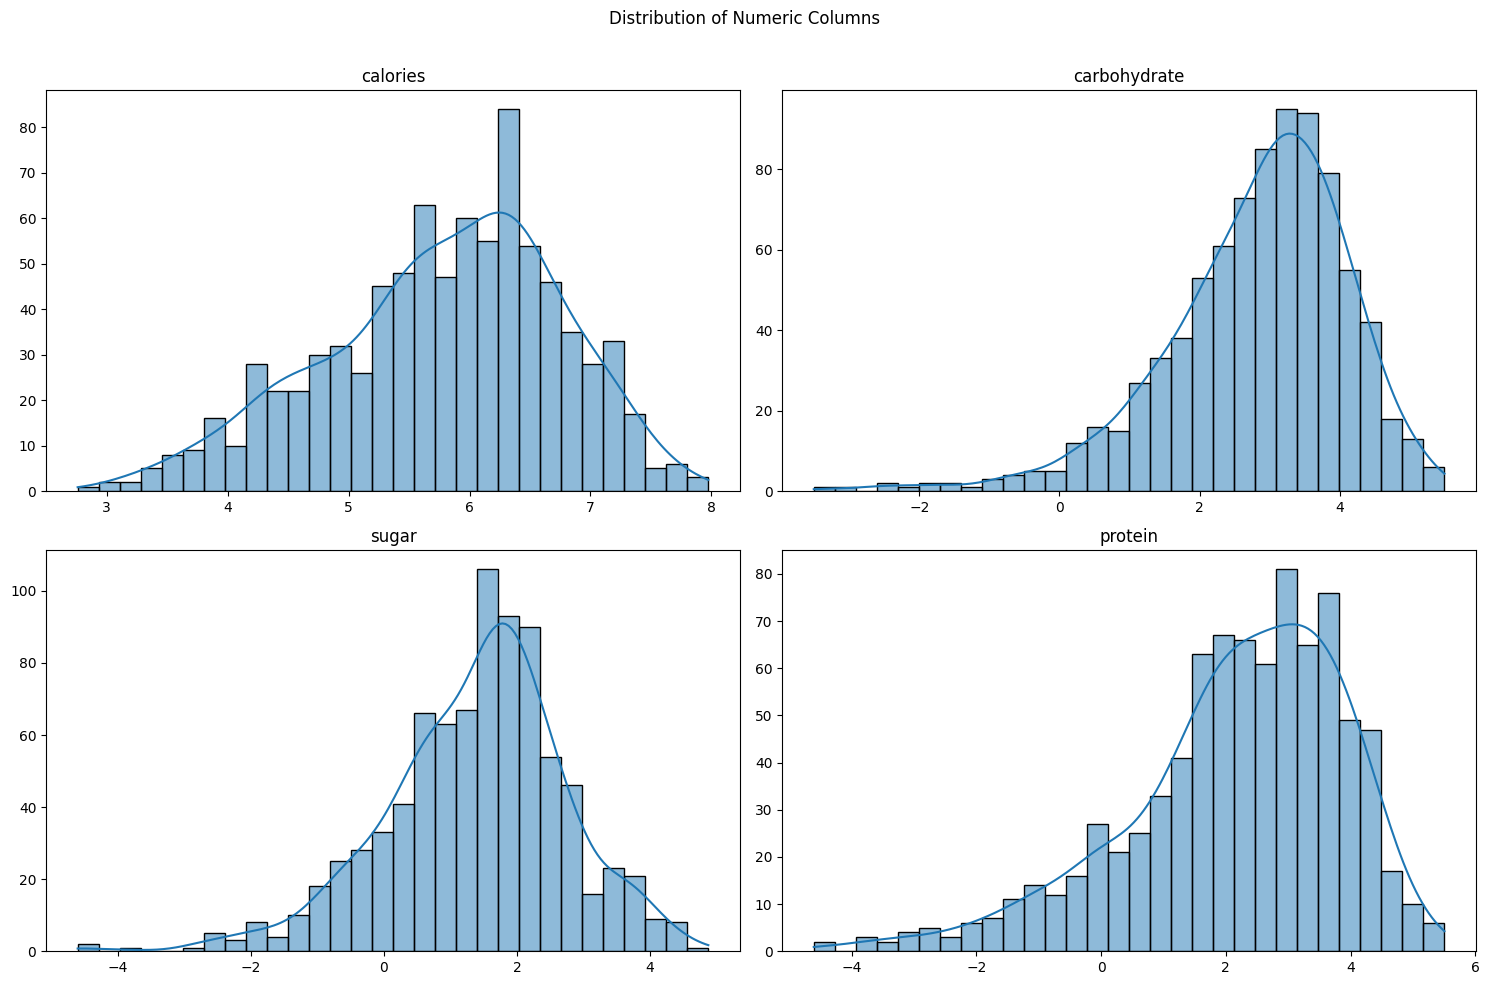

In [118]:
recipe_data[numeric_columns] = np.log(recipe_data[numeric_columns])

f, axes = plt.subplots(2, 2, figsize=(15, 10))
f.suptitle('Distribution of Numeric Columns')

axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(recipe_data[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Adjust title position
plt.show()

In [119]:
recipe_data.replace([np.inf, -np.inf], np.nan, inplace=True)
recipe_data.dropna(subset=numeric_columns, inplace=True)

Next, we will do a one-hot encoding for 'category', label encoding for the 'high_traffic' variable, and scale the features. 

In [120]:
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# One-hot encoding the category column
recipe_data_processed = pd.get_dummies(recipe_data, columns=['category'], prefix='', prefix_sep='')
# Label encoding the high_traffic column
le = LabelEncoder()
recipe_data_processed['high_traffic'] = le.fit_transform(recipe_data_processed['high_traffic'])
# Splitting into features and target
X = recipe_data_processed.drop(columns=['high_traffic'])  
y = recipe_data_processed['high_traffic']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Scaling the numeric columns
scaler = StandardScaler()
scaler.fit(X_train[numeric_columns]) 
X_train[numeric_columns] = scaler.transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])




● Response Variable: 'high_traffic' is binary variable that takes either 'High' or 'Low’ values. As such, we will test models applicable to binary response variable, such as Logistic Regression, K nearest neighbors, and Gradient Boosting Tree.

● Evaluation Metric: Our key metric is precision. Given the vast recipe pool and the few highlighted on the main page, our priority is choosing correctly, not necessarily catching all popular ones. This approach favors precision over recall or accuracy. The aim is to confidently showcase, say, 5 top recipes to guarantee a positive user experience.

**Logistic Regression**

In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Initializing the model and grid search
logreg_cv = LogisticRegression(max_iter=1000, penalty = 'l2')
grid_search = GridSearchCV(logreg_cv, param_grid, cv=5, scoring='precision')

# Fit the model
grid_search.fit(X_train, y_train)

# Results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-validation Score: {grid_search.best_score_:.4f}")

Best Parameters: {'solver': 'liblinear'}
Best Cross-validation Score: 0.6865


In [122]:
logreg = LogisticRegression(max_iter = 1000, penalty='l2', solver=grid_search.best_params_['solver'])

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Calculate the precision score
prec_score = precision_score(y_test, y_pred)

print(f"Precision Score: {prec_score:.4f}")

Precision Score: 0.7581


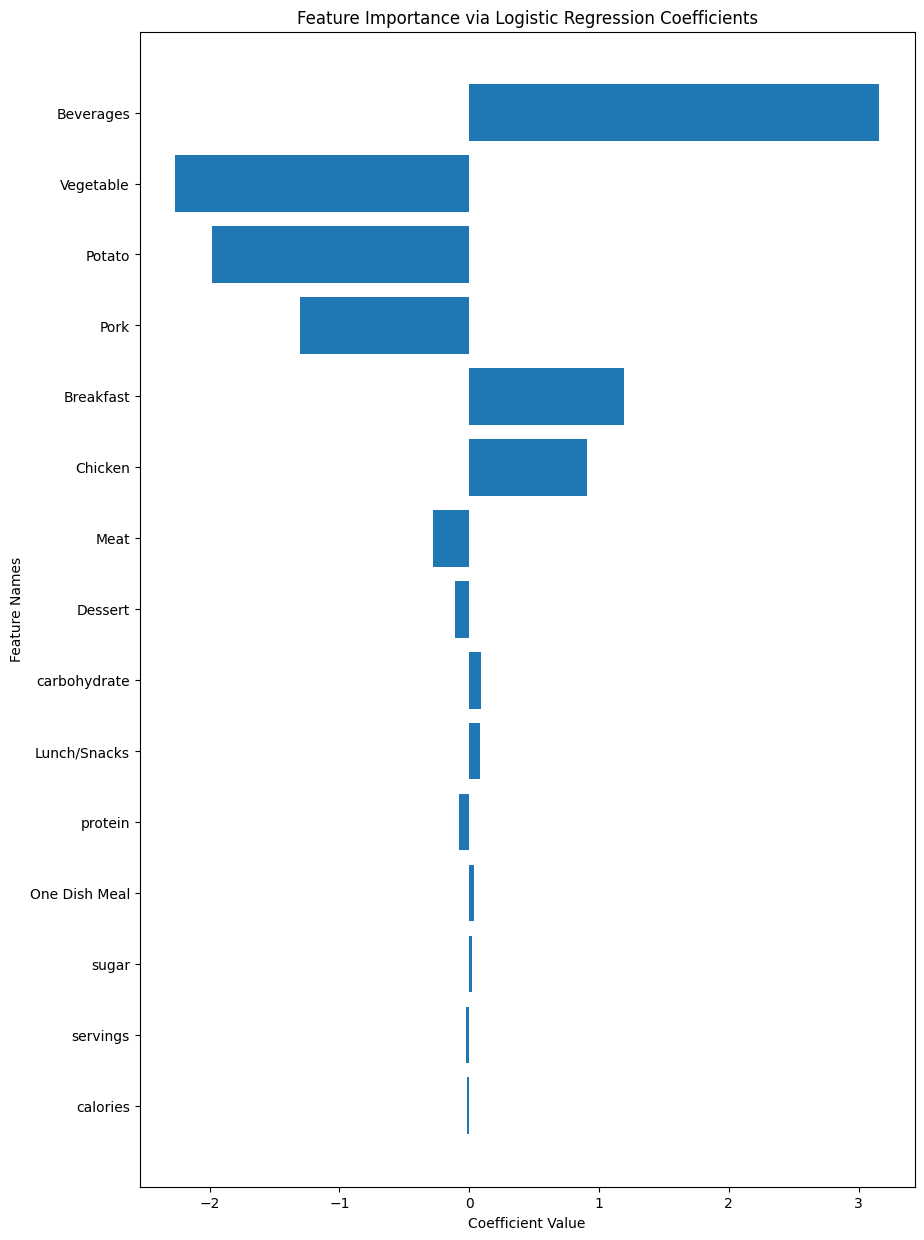

In [123]:

feature_names = X_train.columns
coefficients = logreg.coef_[0]

# Pair them up in a tuple and sort by coefficient value
feature_importance = sorted(list(zip(feature_names, coefficients)), key=lambda x: abs(x[1]), reverse=True)

# Separate the tuples for plotting
features, coeffs = zip(*feature_importance)

# Plot
plt.figure(figsize=(10, 15))
# Reverse the order for plotting
plt.barh(features[::-1], coeffs[::-1])
plt.title('Feature Importance via Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Names')
plt.show()

Numeric Feature Insight: Confirming the EDA insight, numeric features don't significantly influence traffic predictions.

**K-Nearest Neighbours**

In [124]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize KNN and GridSearchCV
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='precision', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-validation Score: {grid_search.best_score_:.4f}")

# Train KNN with the best hyperparameters
knn_best = KNeighborsClassifier(**grid_search.best_params_)
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)

# Calculate the precision score
prec_score = precision_score(y_test, y_pred)
print(f"Precision Score: {prec_score:.4f}")



Best Parameters: {'metric': 'euclidean', 'n_neighbors': 24, 'weights': 'uniform'}
Best Cross-validation Score: 0.7437
Precision Score: 0.6471


**Gradient Boosting Classifier**

In [125]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.9],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize GradientBoostingClassifier
gb_model = GradientBoostingClassifier()

# Setup GridSearchCV optimized for precision
grid_search = GridSearchCV(gb_model, param_grid, scoring='precision', cv=5, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

print("Precision:", precision_score(y_test, y_pred))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Precision: 0.85


In [126]:
final_model = GradientBoostingClassifier(**grid_search.best_params_)

final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)

final_precision = precision_score(y_test, y_pred_final)

print("Final Model Precision:", final_precision)

Final Model Precision: 0.8421052631578947


In [127]:
from sklearn.utils import resample

# The final model configuration
precision_scores_bootstrap = []

# Number of iterations
n_iterations = 1000

# Size for each sampled dataset
n_size = int(len(X_train) + len(X_test))

for i in range(n_iterations):
    # Resample the data with replacement
    X_resampled, y_resampled = resample(X, y, n_samples=n_size)
    
    # Split into train and test sets
    X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2)
    
    # Train and evaluate the model
    final_model.fit(X_train_resampled, y_train_resampled)
    y_pred = final_model.predict(X_test_resampled)
    
    prec = precision_score(y_test_resampled, y_pred)
    precision_scores_bootstrap.append(prec)

# Checking the percentage of precision scores above 80%
above_80 = sum([1 for x in precision_scores_bootstrap if x >= 0.8]) / n_iterations

print(f"Percentage of iterations with precision >= 80%: {above_80*100:.2f}%")


Percentage of iterations with precision >= 80%: 91.90%


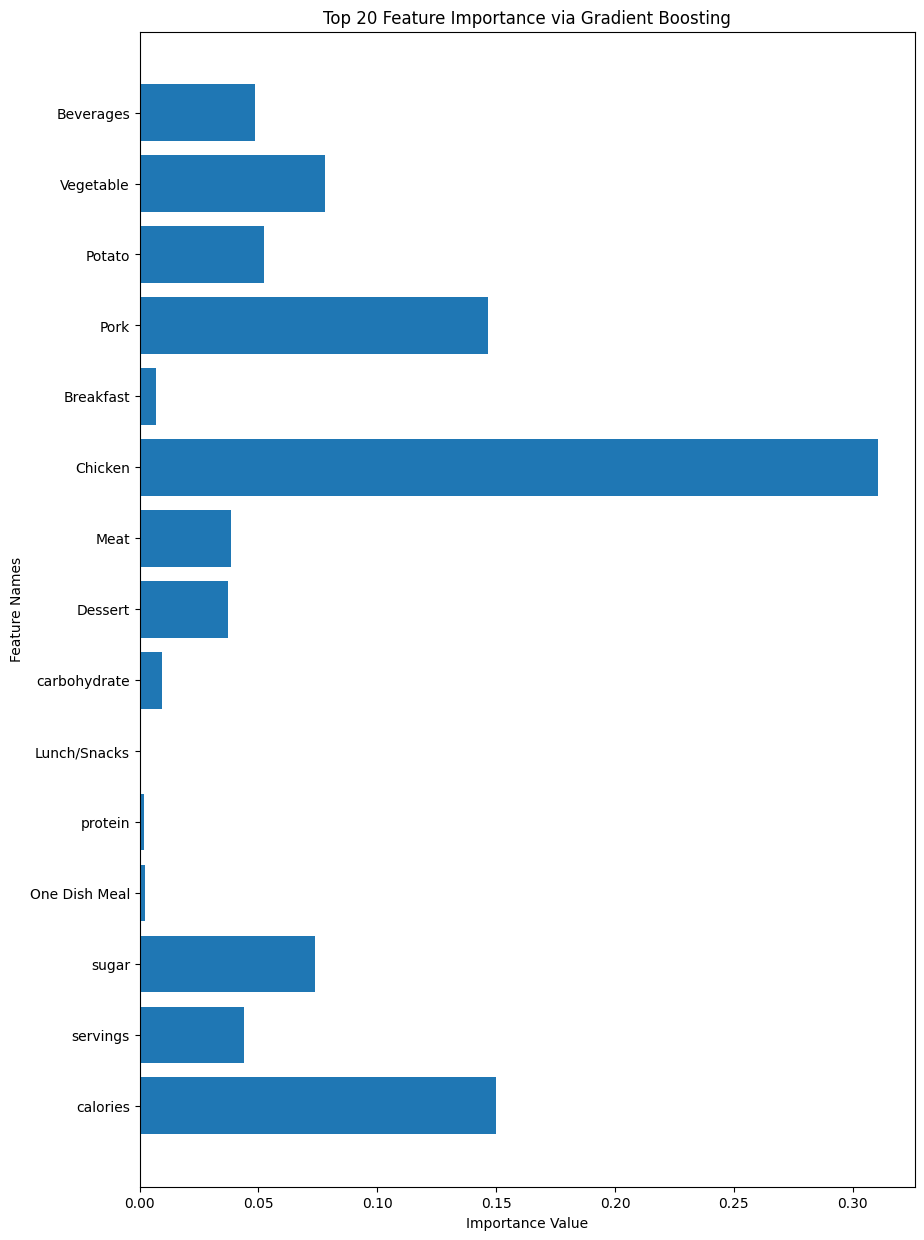

In [128]:
feature_importances = final_model.feature_importances_

# Pair them up in a tuple and sort by importance value
sorted_importance = sorted(list(zip(feature_names, feature_importances)), key=lambda x: x[1], reverse=True)

top_features, top_importances = features[:20], feature_importances[:20]

plt.figure(figsize=(10, 15))
plt.barh(top_features, top_importances)
plt.title('Top 20 Feature Importance via Gradient Boosting')
plt.xlabel('Importance Value')
plt.ylabel('Feature Names')
plt.gca().invert_yaxis()  
plt.show()


● The Gradient Boosting Classifier is the only model that consistently hits a precision score above 80%. Using 1000 bootstrap samples, we determine that 91.6% of iterations hits precision score above 80%.

● We made an importance chart using the gradient boosting classifier and compared it to the logistic regression's. While the category hierarchy is similar in both, the gradient boosting emphasizes numeric variables more. We should refine the nutritional data further to ensure this trend isn't just noise from faulty data.

